# Ejemplos básicos de algoritmos en paralelo.

- Ortega Ibarra Jaime Jesús.
- Jonathan José Martiñón Luna.
- José de Jesús Tapia López

## Paralelismo utilizando ray
Ray es un proyecto de código abierto para Python paralelo y distribuido.
- Ray toma los conceptos existentes de funciones y clases y los traduce a la configuración distribuida como Tareas y actores. Esta opción de API permite que las aplicaciones en serie se realicen en paralelo sin modificaciones importantes.

### Instalación

In [2]:
pip install ray

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install setproctitle

Note: you may need to restart the kernel to use updated packages.


### Ray.init()
El $ray.init()$ comando inicia todos los procesos Ray relevantes. 
En un clúster, esta es la única línea que debe cambiar (debemos pasar la dirección del clúster). Estos procesos incluyen lo siguiente:
- Varios procesos de trabajo para ejecutar funciones de Python en paralelo (aproximadamente un trabajador por núcleo de CPU).
- Un proceso de planificación para asignar "tareas" a los trabajadores (y a otras máquinas). Una tarea es la unidad de trabajo programada por Ray y corresponde a una invocación de función o invocación de método.
- Un almacén de objetos de memoria compartida para compartir objetos de manera eficiente entre trabajadores (sin crear copias).
Los trabajadores de Ray son procesos separados en lugar de subprocesos porque la compatibilidad con subprocesos múltiples en Python es muy limitada debido al bloqueo global del intérprete .

In [2]:
import random as rd
import ray
ray.init()

2019-11-24 16:35:49,072	INFO resource_spec.py:205 -- Starting Ray with 1.71 GiB memory available for workers and up to 0.88 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.1.78',
 'redis_address': '192.168.1.78:43660',
 'object_store_address': '/tmp/ray/session_2019-11-24_16-35-49_071349_5246/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-11-24_16-35-49_071349_5246/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-11-24_16-35-49_071349_5246'}

In [5]:
import numpy as np
import time
import datetime
@ray.remote
def creamatriz(size):
    return np.random.normal(size=size)

@ray.remote
def multiplicamatriz(x, y):
    return np.dot(x, y)


t = time.time()
x_id = creamatriz.remote([1000, 1000])
y_id = creamatriz.remote([1000, 1000])
z_id = multiplicamatriz.remote(x_id, y_id)
# Get the results.
z = ray.get(z_id)
print(z.shape)
print("Tiempo paralelo: ", (time.time()-t))

(1000, 1000)
Tiempo paralelo:  0.49037909507751465


In [6]:
def creamatriz(size):
    #print(datetime.datetime.now())
    return np.random.normal(size=size)
def multiplicamatriz(x, y):
    #print(datetime.datetime.now())
    return np.dot(x, y)
t2 = time.time()
x = creamatriz([1000,1000])
y = creamatriz([1000,1000])
c = multiplicamatriz(x, y)
print(c.shape)
print("Tiempo serie: ", (time.time()-t2))

(1000, 1000)
Tiempo serie:  0.13251543045043945


### Distrubución de Tareas.
La distribución de tareas se pueden usar de formas mucho más sofisticadas. Por ejemplo, supongamos que deseamos agregar 8 valores juntos. Este ejemplo utiliza la suma de enteros, pero en muchas aplicaciones, agregar vectores grandes en varias máquinas puede ser un cuello de botella. En este caso, cambiar una sola línea de código puede cambiar el tiempo de ejecución de la agregación de lineal a logarítmico en la cantidad de valores que se agregan, tal como se observa en la siguiente imagen.

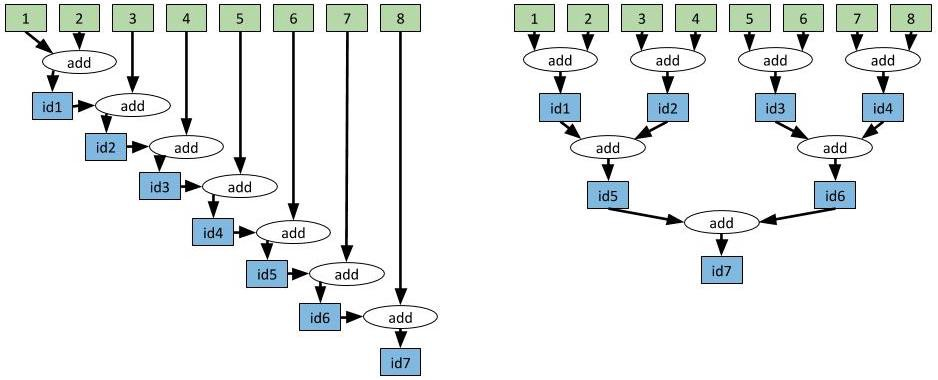

In [7]:
from IPython.display import Image
Image("dependenciatareas.png", width=550, height=500)

In [8]:
import time
import datetime
@ray.remote
def add(x, y):
    #print("Tiempo entrada",datetime.datetime.now())
    time.sleep(1)
    c = x + y
    #print("Tiempo salida",datetime.datetime.now())
    return c

#Tiempo constante O(n)
t = time.time()
valor1 = add.remote(1, 2)
valor2 = add.remote(valor1, 3)
valor3 = add.remote(valor2, 4)
valor4 = add.remote(valor3, 5)
valor5 = add.remote(valor4, 6)
valor6 = add.remote(valor5, 7)
valor7 = add.remote(valor6, 8)
resultado = ray.get(valor7)
print("Resultado sin distribución",resultado)
print("Tiempo:", (time.time()-t))

#Tiempo Olog(n)
t2 = time.time()
valor1 = add.remote(1, 2)
valor2 = add.remote(3, 4)
valor3 = add.remote(5, 6)
valor4 = add.remote(7, 8)
valor5 = add.remote(valor1, valor2)
valor6 = add.remote(valor3, valor4)
valor7 = add.remote(valor5, valor6)
resultado2 = ray.get(valor7)
print("Resultado con distribucion", resultado2)
print("Tiempo:", (time.time()-t2))

Resultado sin distribución 36
Tiempo: 7.034784555435181
Resultado con distribucion 36
Tiempo: 3.01287579536438


In [1]:
@ray.remote

class Prod_Cons(object):
    
    def __init__(self):
        global buffer
        self.buffer = buffer
    
    def productor(self):
        self.prod = rd.randint(1,5)
        self.buffer += self.prod
        #self.buffer += 2
        print("Productor produce",self.prod,"item, Queda en Buffer:", self.buffer)
        return self.buffer
    
    def consumidor(self):
        if self.buffer > 0:
            self.buffer -= 1
            print("Consumidor consume item, Queda en Buffer:", self.buffer)
            return self.buffer
        
    
P = Prod_Cons.remote()
buffer = 10
while True:
    P.productor.remote()
    P.consumidor.remote()
    P.consumidor.remote()
    P.consumidor.remote()

NameError: name 'ray' is not defined